In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import gpxpy

In [3]:
import pandas as pd
import numpy as np
import datetime

In [4]:
def test_point(point):
    return (point.time != None) &\
           (point.latitude != None) &\
           (point.longitude != None)

In [5]:
def get_df_from_gpx(gpx):
    
    df = pd.DataFrame(columns=['time','lat','lon'])
    times=[]
    stamps=[]
    lats=[]
    lons=[]
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                if test_point(point):
                    times.append(point.time)
                    stamps.append(point.time.timestamp())
                    lats.append(point.latitude)
                    lons.append(point.longitude)
                else: pass
    df = pd.DataFrame(data={'time':times,'timestamp':stamps,'lat':lats,'lon':lons})

    df.sort_values('timestamp', inplace=True)

    df['timestamp'] = df['timestamp'].astype('int')

    df['dtime'] = df.timestamp.values - df.timestamp.min()

    return df

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import matplotlib.dates as mdates

In [8]:
from os import listdir
from os.path import isfile, join
onlyfiles = [join('../gps_data/', f) for f in listdir('../gps_data/') if isfile(join('../gps_data/', f))]

In [9]:
def check_berlin(df):
    berlin_lat = lambda x: 40 <= x <= 60
    berlin_lon = lambda x: 12 <= x <= 14
    
    return (berlin_lon(df.lon.min()) | \
            berlin_lon(df.lon.max())) & \
           (berlin_lat(df.lat.min()) | \
            berlin_lat(df.lat.max()))

In [10]:
#gpxfile = onlyfiles[10] #0 #10 # 6
gpxfile = '../gps_data/2778884.gpx'
gpx = gpxpy.parse(open(gpxfile, 'r'))
df = get_df_from_gpx(gpx)

In [11]:
import folium

colors = ['green','darkgreen','lightgreen','darkblue','lightblue',
          'red','blue','gray','darkred','orange','beige',
          'purple','pink','cadetblue','lightgray','black'] 
# 'lightred','darkpurple'

In [12]:
home_coords = [0.5*(df.lat.max()+df.lat.min()), 0.5*(df.lon.max()+df.lon.min())] 

In [13]:
m = folium.Map(location=home_coords, width='60%', height='100%', top='0%',
                   zoom_start=12, tiles='CartoDBpositron', control_scale=True)

len_colors=len(colors)

lons = df.lon.values
lats = df.lat.values
coords = list(zip(lats,lons))
print(len(coords))

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]
    folium.PolyLine(coco, color=colors[n%len_colors]).add_to(m)    
m    

2027


In [14]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

# then cast your geographic coordinate pair to the projected system
projx, projy = proj.transform(crs_wgs, crs_bng, df["lon"].values, df["lat"].values)

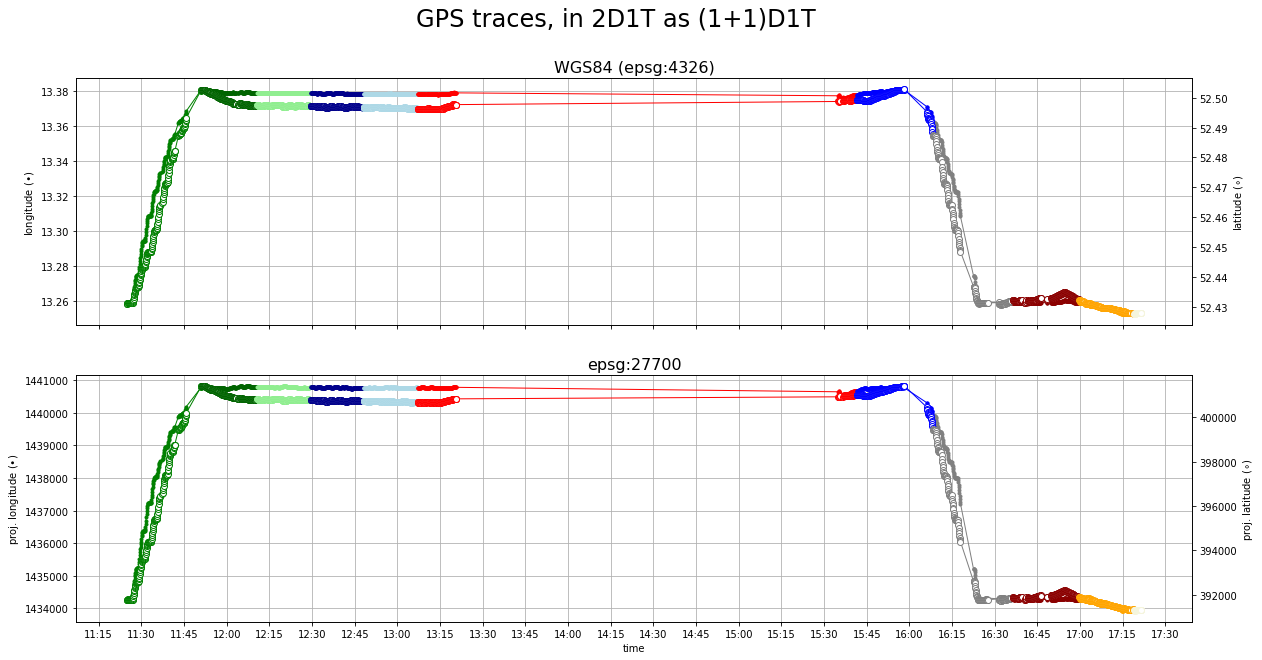

In [20]:
locator = mdates.AutoDateLocator(minticks=24, maxticks=36)


fig, axs= plt.subplots(2,1, figsize=[20,10])


axs = axs.flatten()

ax = axs[0]

axt = ax.twinx()

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]

    ax.plot(df.time.values[nn:nnn], df.lon.values[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df.time.values[nn:nnn], df.lat.values[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    
ax.set_xticklabels([],visible=False)

axt.set_ylabel(r"latitude ($\circ$)")
ax.set_ylabel(r"longitude ($\bullet$)")
#ax.set_xlabel("time")
ax.set_title("WGS84 (epsg:4326)", fontsize=16)
ax.grid()

ax = axs[1]
axt = ax.twinx()

for n in range(50):
    nn = n*200
    nnn = (n+1)*200
    coco = coords[nn:nnn]

    ax.plot(df.time.values[nn:nnn], projx[nn:nnn], '.-', color=colors[n%len_colors], lw=1)
    axt.plot(df.time.values[nn:nnn], projy[nn:nnn], 'o-', markerfacecolor='w',markeredgewidth=1, color=colors[n%len_colors], lw=1)    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locator)    

axt.set_ylabel(r"proj. latitude ($\circ$)")
ax.set_ylabel(r"proj. longitude ($\bullet$)")
ax.set_xlabel("time")
ax.set_title("epsg:27700", fontsize=16)
ax.grid();
fig.suptitle('GPS traces, in 2D1T as (1+1)D1T', fontsize=24);